# Sparse Sheaf Signal Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from vdm import VDM
import cvxpy as cp
from sklearn.linear_model import OrthogonalMatchingPursuit
from wavelet import Wavelet
from builder import CochainSample # builder.py file provided by project supervisor
import pandas as pd
from utils import fibonacci_sphere, geodetic_to_ecef, project_to_tangent
import warnings
warnings.filterwarnings("ignore")

SEED = 6111983
np.random.seed(SEED)

# Synthetic Datasets

## Random Point Cloud in a Cube

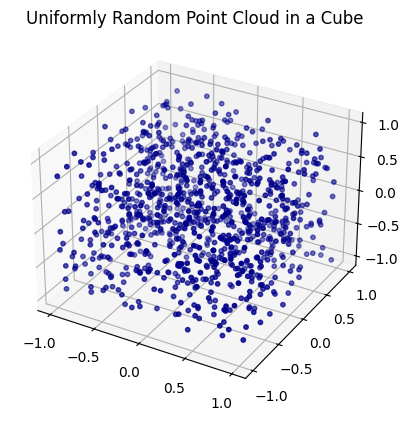

In [2]:
# Generate a cube in R^3 with uniformly random points
N = 1000 # number of points in the cloud
np.random.seed(6111983)
cube_point_cloud = np.random.uniform(-1,1,N*3).reshape((N, 3)) # points
# Plot the cube
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cube_point_cloud[:,0], cube_point_cloud[:,1], cube_point_cloud[:,2], marker='o', s=10, c='darkblue')
plt.title('Uniformly Random Point Cloud in a Cube')
plt.show()

#### VDM

In [6]:
x = cube_point_cloud  # data
eps = 0.15 # epsilon for the graph
eps_pca = 0.1 # epsilon for the local PCA
k = 30 # number of neighbors in knn
gamma = 0.95 # information variability threshold in dimension estimation with singular values

# Create the vdm object
vdm = VDM(x, eps, eps_pca, k, gamma)

# Create the graph
G = vdm.make_graph(method='radius') # method must be 'radius' or 'knn', the default is 'radius'
# 'radius': radius nearest neighbors adds an edge (i,j) if ||x[i]-x[j]|| < sqrt(eps)   -> hyperparameter eps
# 'knn': adds edges between a node and its k nearest neighbors       -> hyperparameter k

# Print manifold dimension
print(f"Estimated dimension of the manifold: {vdm.estimate_dim()}")

Estimated dimension of the manifold: 2


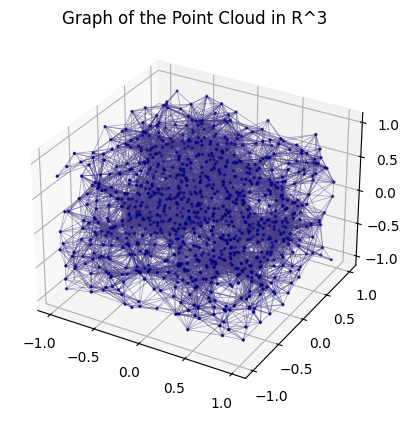

In [7]:
# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='navy')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='darkslateblue', linewidth=0.5, alpha=0.5)
plt.title('Graph of the Point Cloud in R^3')
plt.show()

#### Build the Laplacians

##### Connection Laplacian

In [ ]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L_con = vdm.connection_laplacian() # approximation of the connection laplacian

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(L_con)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

##### Trivial Laplacian

In [ ]:
# Graph Laplacian
W = vdm.get_weight_matrix() # Weight matrix
d = vdm.get_degree_vector() # degree vector
d_sqrt = np.sqrt(d)
L_trivial = np.diag(d) - W # Graph Laplacian
L_trivial_norm = np.diag(1./d_sqrt) @ L_trivial @ np.diag(d_sqrt) # Normalized Laplacian

### Generate Signals

## Fibonacci Sphere

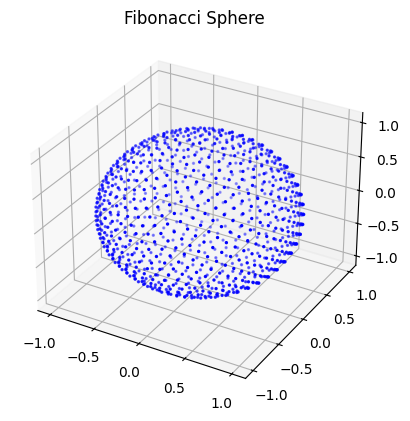

In [3]:
N = 1000 # number of points
sphere_points = fibonacci_sphere(N) # Generate the Fibonacci sphere

# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sphere_points[:,0], sphere_points[:,1], sphere_points[:,2], marker='o', s=2, c='blue')
plt.title('Fibonacci Sphere')
plt.show()

In [ ]:
x = fibonacci_sphere  # data
eps = 0.15 # epsilon for the graph
eps_pca = 0.1 # epsilon for the local PCA
k = 30 # number of neighbors in knn
gamma = 0.95 # information variability threshold in dimension estimation with singular values

# Create the vdm object
vdm = VDM(x, eps, eps_pca, k, gamma)

# Create the graph
G = vdm.make_graph(method='radius') # method must be 'radius' or 'knn', the default is 'radius'

# Print manifold dimension
print(f"Estimated dimension of the manifold: {vdm.estimate_dim()}")

In [ ]:
# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='navy')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='darkslateblue', linewidth=0.5, alpha=0.5)
plt.title('Graph of the Point Cloud in R^3')
plt.show()

#### Build the Laplacian

##### Connection Laplacian

In [ ]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L_con = vdm.connection_laplacian() # approximation of the connection laplacian

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(L_con)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

##### Trivial Laplacian

In [ ]:
# Graph Laplacian
W = vdm.get_weight_matrix() # Weight matrix
d = vdm.get_degree_vector() # degree vector
d_sqrt = np.sqrt(d)
L_trivial = np.diag(d) - W # Graph Laplacian
L_trivial_norm = np.diag(1./d_sqrt) @ L_trivial @ np.diag(d_sqrt) # Normalized Laplacian

# Weather Dataset

### Load the Dataset

A csv file is loaded, containing Swiss weather station coordinates and heights. The stations will be the nodes in the graph built by the VDM class.

In [2]:
stations = pd.read_csv('stations_ds.csv')
display(stations)

,nat_abbr,latitude,longitude,station_height
0,ABE,47.057969,7.285350,444.00
1,ABO,46.491703,7.560703,1321.38
2,AEG,47.133636,8.608206,724.43
3,AFI,47.604669,8.670289,360.00
4,AGATT,47.265233,8.050519,475.00
...,...,...,...,...
297,WYN,47.255025,7.787475,421.99
298,ZER,46.029272,7.752433,1638.35
299,ZEV,46.578797,9.118797,1738.00
300,ZWE,46.550511,7.384917,936.00


In [3]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nat_abbr        302 non-null    object 
 1   latitude        302 non-null    float64
 2   longitude       302 non-null    float64
 3   station_height  302 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.6+ KB


In [4]:
# Turn columns 1,2,3 (latitude, longitude, station_height) to a numpy array
station_geodetic = stations.iloc[:,1:4].to_numpy()
# Turn the coordinates from geodetic to R^3 points
x, y, z = geodetic_to_ecef(
    station_geodetic[:, 0],
    station_geodetic[:, 1],
    station_geodetic[:, 2]
)
station_points = np.column_stack((x, y, z))  # shape (N, 3)
station_points[:10]

array([[0.67575819, 0.08639101, 0.73204334],
       [0.68247416, 0.09058512, 0.72527468],
       [0.6726272 , 0.10182383, 0.7329424 ],
       [0.66653709, 0.10164081, 0.73851029],
       [0.67191781, 0.09503612, 0.73450296],
       [0.6698307 , 0.09771763, 0.73605577],
       [0.67498515, 0.09174883, 0.73210464],
       [0.68550921, 0.08325283, 0.72328838],
       [0.68029226, 0.10285349, 0.72568836],
       [0.66769497, 0.11241116, 0.73589888]])

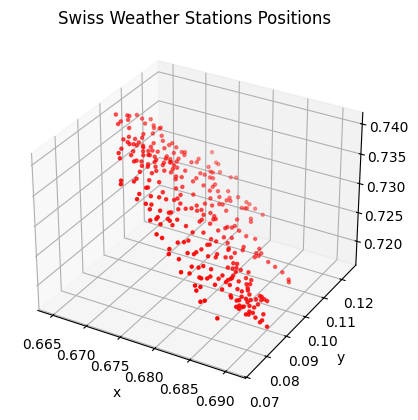

In [5]:
# Plot the cube
fig = plt.figure()  
ax = fig.add_subplot(projection='3d')
ax.scatter(station_points[:,0], station_points[:,1], station_points[:,2], marker='o', s=5, c='red')
plt.title('Swiss Weather Stations Positions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Find some distance statistics to choose good hyperparameters for the VDM class
def compute_distances(x):
    distances = []
    for i in range(x.shape[0]):
        for j in range(i+1, x.shape[0]):
            dist = np.linalg.norm(x[i] - x[j])
            distances.append(dist)
    return distances

distances = compute_distances(station_points)
print(f"Median distance between two stations: {np.median(distances)}")
print(f"Min and max distances: {np.min(distances)}, {np.max(distances)}")
print("First ten distances:")
print(sorted(distances, reverse=True)[:10])

Median distance between two stations: 0.01761227600907149
Min and max distances: 0.00037039650947565583, 0.05318045111323205
First ten distances:
[np.float64(0.05318045111323205), np.float64(0.05287267455556982), np.float64(0.052071312343405105), np.float64(0.05204996461640956), np.float64(0.05143259099883185), np.float64(0.050794923114699214), np.float64(0.05078056824714675), np.float64(0.05060660727475896), np.float64(0.050562648945038736), np.float64(0.05055124190410377)]


### Build the Graph

In [63]:
x = station_points  # point cloud
eps = 0.0003 # epsilon for the graph
eps_pca = 0.0002 # epsilon for the local PCA
k = 15 # number of neighbors in knn
gamma = 0.997 # information variability threshold in dimension estimation with singular values
vdm = VDM(x, eps, eps_pca, k, gamma)
G = vdm.make_graph()
print(f"Estimated dimension of the manifold: {vdm.estimate_dim()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph density: {G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1))}")

Estimated dimension of the manifold: 2
Number of edges: 22196
Graph density: 0.244175045653561


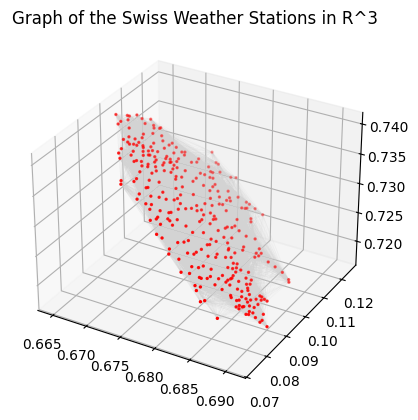

In [64]:
# Plot the graph
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='red')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='lightgrey', linewidth=0.1, alpha=0.5)
plt.title('Graph of the Swiss Weather Stations in R^3')
plt.show()

### Build the Laplacians

##### Connection Laplacian

In [8]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L_con = vdm.connection_laplacian() # approximation of the connection laplacian

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(L_con)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
# Suppress imaginary part if below 1e-15
for i in range(len(eigvals)):
    if np.abs(eigvals[i].imag) < 1e-15:
        eigvals[i] = eigvals[i].real
# If all values are real now, change data type from complex to float
if np.all(np.isreal(eigvals)):
    eigvals = eigvals.astype(np.float64)
print("Complex parts were suppressed because they were all below a 1e-15 tolerance. Data type changed to float64.")
print(f"Min eigenvalue: {eigvals[0]}, Max eigenvalue: {eigvals[-1]}")

Complex parts were suppressed because they were all below a 1e-15 tolerance. Data type changed to float64.
Min eigenvalue: -1.4941219944218032, Max eigenvalue: -0.25608233336434905


##### Trivial Bundle

In [ ]:
# Graph Laplacian
W = vdm.get_weight_matrix() # Weight matrix
d = vdm.get_degree_vector() # degree vector
d_sqrt = np.sqrt(d)
L_trivial = np.diag(d) - W # Graph Laplacian
L_trivial_norm = np.diag(1./d_sqrt) @ L_trivial @ np.diag(d_sqrt) # Normalized Laplacian

### Load Signals

In [108]:
# Load the signals (wind data)
wind_data_uv = np.load('wind_data_uv.npy')
wind_data_uv

array([[-0.9986295 , -0.33456534, -0.93358046, ...,  0.39999998,
         0.9801073 ,  0.52484727],
       [-0.05233597,  0.37157238,  0.35836792, ...,  0.69282037,
        -0.4993893 ,  0.60376763],
       [-0.70139384, -0.68404025, -0.70331603, ...,  1.4571847 ,
         1.0790098 , -0.03838944],
       ...,
       [-2.9870312 , -3.11127   , -3.5460484 , ..., -0.5846221 ,
        -0.48480958, -0.9563047 ],
       [ 0.76604456,  0.7269508 ,  0.7551845 , ...,  0.9439806 ,
         0.860083  ,  1.2362019 ],
       [ 0.6427875 ,  1.0777488 ,  0.9325752 , ...,  1.165719  ,
         2.2405932 ,  3.0597064 ]], shape=(302, 5616), dtype=float32)

In [119]:
u = wind_data_uv[::2,:] # zonal (east–west) wind component
v = wind_data_uv[1::2,:] # meridional (north–south) wind component
# Take the first signal
uv_signal = np.column_stack((u[:,0],v[:,0]))
uv_signal.shape

(151, 2)

In [120]:
uv_signal.shape

(151, 2)

In [123]:
O = vdm.make_orthonormal_bases()
len(O)

302

In [ ]:
# Project the signal point-wise on the tangent space of the graph
O = vdm.make_orthonormal_bases()
# ...